## Imports

In [1]:
import os
import datetime
from tqdm.auto import tqdm
import numpy as np
from timeit import default_timer as timer
from PIL import Image

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

# add directory to path so we can import modules from src
import sys
sys.path.append("../src")

## AudioFile class

In [ ]:
from team14 import AudioFile

_audio_file = '../data/audio/Speech Commands/forward/0a2b400e_nohash_0.wav'
test_audio = AudioFile(_audio_file)

test_audio.play()
test_audio.display_waveform()
test_audio.display_spectrogram()
test_audio.trim(top_db=40)

## Convert Audio Files to Spectrograms

 - set input_dir and output_dir accordingly
 - call process_directory()
 - if skip_existing is True, existing spectrogram PNG files will be skipped (recommended)


### NOTE:

- Only run this cell if you need to save out all the spectrograms. It takes awhile, and is prone to crashing (hence the use of skip_existing, so it can continue where it left off).
- Commented out the "process_directory(...)" line at the bottom to avoid accidental runs

In [ ]:
def process_directory(input_dir, skip_existing=True, include_trimmed=False):
    output_dir = os.path.join("data", "images", os.path.basename(input_dir))
    output_dir_trimmed = os.path.join(output_dir + " (trimmed)")
    for root, dirs, files in os.walk(input_dir):
        # sort directories alphabetically
        dirs.sort()
        directory = os.path.basename(root)
        print(f"Processing directory: {directory}")
        for file in files:
            if file.endswith('.wav'):
                audio = None
                # trim off .wav from file
                base, _ = os.path.splitext(file)
                output_file = os.path.join(output_dir, directory, base + ".png")
                
                if not (skip_existing and os.path.exists(output_file)):
                    # load file
                    audio = AudioFile(os.path.join(root, file))
                    # save spectrogram
                    audio.save_spectrogram(output_dir, skip_existing=skip_existing)

                if include_trimmed:
                    output_file_trimmed = os.path.join(output_dir_trimmed, directory, base + ".png")
                    if not (skip_existing and os.path.exists(output_file_trimmed)):
                        # have we loaded the file already?
                        if not audio:
                            audio = AudioFile(os.path.join(root, file))
                        # trim and save
                        audio.trim()
                        audio.save_spectrogram(output_file_trimmed, skip_existing=skip_existing)
                
process_directory('data/audio/Speech Commands_noise', skip_existing=True, include_trimmed=False)

### Corrupt image check

In [ ]:
# Define your directories
output_dir = os.path.join("data", "images", "Speech Commands")
output_dir_trimmed = os.path.join("data", "images", "Speech Commands (trimmed)")

def check_png_corruption(directories, output_file="corrupt_pngs.txt"):
    corrupt_files = []
    for directory in directories:
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.lower().endswith('.png'):
                    file_path = os.path.join(root, file)
                    try:
                        with Image.open(file_path) as img:
                            img.verify()  # This will raise an exception if the file is corrupted.
                    except Exception as e:
                        print(f"Corrupted PNG found: {file_path} (Error: {e})")
                        corrupt_files.append(file_path)

    # Write the results to a text file
    if corrupt_files:
        with open(output_file, "w") as f:
            for filename in corrupt_files:
                f.write(f"{filename}\n")
        print(f"Found {len(corrupt_files)} corrupt PNG(s). Details saved to '{output_file}'.")
    else:
        print("No corrupt PNG files found.")

# List of directories to check
directories_to_check = [output_dir, output_dir_trimmed]

# Run the check
check_png_corruption(directories_to_check)

## Convolutional Neural Net

#### Setup and Parameters

In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"  # Apple Metal Performance Shaders
else:
    device = "cpu"

print(f"Using {device} device")


datetime_stamp = datetime.datetime.now().strftime('%y%m%d-%H%M')

# setup tensorboard
writer_path = f"../logs/run_{datetime_stamp}"
writer = SummaryWriter(writer_path)

# path to save model
model_path = f"../models/cnn_ryan/{datetime_stamp}"
            

## PARAMETERS ##
image_size = (256, 190) # from 496x369. Closely maintains aspect ratio
num_channels = 3 # RGB images
# for DataLoader
batch_size = 64
num_workers = 2

Using mps device


 #### Transform and Load data 

In [3]:
from team14 import SpeechCommandsDataset

data_transforms = transforms.Compose([
    transforms.Resize((image_size[0], image_size[1])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# load splits from text files
with open('../docs/training_list.txt', 'r') as f:
    training_list = f.read().splitlines()

with open('../docs/validation_list.txt', 'r') as f:
    validation_list = f.read().splitlines()

with open('../docs/testing_list.txt', 'r') as f:
    testing_list = f.read().splitlines()

# set dataset root directory
data_dir = "../data/images/Speech Commands (trimmed)"


# create datasets
train_dataset = SpeechCommandsDataset(training_list, data_dir, transform=data_transforms)
val_dataset = SpeechCommandsDataset(validation_list, data_dir, transform=data_transforms)
test_dataset = SpeechCommandsDataset(testing_list, data_dir, transform=data_transforms)

# print data sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

# create data loaders
train_batches = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_batches = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_batches = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# get class labels
class_labels = train_dataset.class_to_idx
num_classes = len(class_labels)
print(f"\nClasses: {num_classes}")


Training set size: 84843
Validation set size: 9981
Testing set size: 11005

Classes: 35


#### Helper Functions

In [ ]:
def display_spectrogram(img):
    img = img / 2 + 0.5     # de-normalize
    plt.axis('off')
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))

def display_spectrogram_batches(batches, writer_path=None):
    _iter = iter(batches)
    images, _ = next(_iter)
    img_grid = torchvision.utils.make_grid(images)
    display_spectrogram(img_grid)

    if writer_path:
        # write to tensorboard
        writer.add_images(writer_path, img_grid.unsqueeze(0))

### __Neural Net Model__


#### ResNet style

In [4]:
from team14.models.ryan_resnet import ResNet, BasicBlock

# 19 layers, using BasicBlock
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
print(summary(model, input_size=(num_channels, image_size[0], image_size[1])))
model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 128, 95]             864
       BatchNorm2d-2          [-1, 32, 128, 95]              64
              ReLU-3          [-1, 32, 128, 95]               0
         ConvLayer-4          [-1, 32, 128, 95]               0
            Conv2d-5          [-1, 64, 128, 95]          18,432
       BatchNorm2d-6          [-1, 64, 128, 95]             128
              ReLU-7          [-1, 64, 128, 95]               0
         ConvLayer-8          [-1, 64, 128, 95]               0
         MaxPool2d-9           [-1, 64, 64, 48]               0
           Conv2d-10           [-1, 64, 64, 48]          36,864
      BatchNorm2d-11           [-1, 64, 64, 48]             128
           Conv2d-12           [-1, 64, 64, 48]          36,864
      BatchNorm2d-13           [-1, 64, 64, 48]             128
       BasicBlock-14           [-1, 64,

#### Training Loop

In [ ]:
# display training time
def display_training_time(start, end):
    total_time = end - start
    print(f"Training time : {total_time:.3f} seconds")
    return total_time

# display training info for each epoch
def display_training_info(epoch, val_loss, train_loss, accuracy, learning_rate):
    accuracy = round(accuracy, 2)
    print(f"\nEpoch: {epoch} | Training loss: {train_loss.item():.3f} | Validation loss: {val_loss.item():.3f} | Accuracy: {accuracy:.2f}% | LR: {learning_rate:.4g}")
    
# calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# training
def train_neural_net(epochs, model, loss_func, optimizer, train_batches, val_batches, stop_patience=4, lr_scheduler=None):
    final_accuracy = 0
    best_val_accuracy = 0
    epochs_without_improvement = 0
            
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # === training ===
        model.train()
        with torch.enable_grad():
            train_loss = 0
            for images, labels in tqdm(train_batches, desc="Training Batches", leave=False):
                images = images.to(device)
                labels = labels.to(device)
                predictions = model(images)
                loss = loss_func(predictions, labels)
                train_loss += loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # update learning rate here if using OneCycleLR
                if isinstance(lr_scheduler, torch.optim.lr_scheduler.OneCycleLR):
                    lr_scheduler.step()

            train_loss /= len(train_batches)


        # === evaluation ===
        val_loss, val_accuracy = 0, 0
        model.eval()
        with torch.inference_mode():
            for images, labels in tqdm(val_batches, desc="Validation Batches", leave=False):
                images = images.to(device)
                labels = labels.to(device)
                predictions = model(images)
                val_loss += loss_func(predictions, labels)
                val_accuracy += accuracy_fn(y_true=labels, y_pred=predictions.argmax(dim=1))

            val_loss /= len(val_batches)
            val_accuracy /= len(val_batches)
            final_accuracy = val_accuracy


        # update learning rate here if using ReduceLROnPlateau
        if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            lr_scheduler.step(val_loss)

        # get current learning rate            
        learning_rate = optimizer.param_groups[0]['lr']

        display_training_info(epoch+1, val_loss, train_loss, val_accuracy, learning_rate)

        # log to tensorboard
        writer.add_scalars("Loss", {"Training": train_loss, "Validation": val_loss}, epoch)
        writer.add_scalar("Accuracy", val_accuracy, epoch)
        writer.add_scalar("Learning Rate", learning_rate, epoch)        

        # save checkpoint
        os.makedirs(model_path, exist_ok=True)
        torch.save(model, f"{model_path}/rn19_epoch_{epoch+1}.pt")
        print(f"Checkpoint saved at epoch {epoch+1} with val accuracy {val_accuracy:.2f}%")

        # save model if validation accuracy improves over best accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0  # reset counter
        else:
            epochs_without_improvement += 1
            print(f"No improvement of validation accuracy for {epochs_without_improvement} epoch(s)")

        if epochs_without_improvement >= stop_patience:
            print(f"Early stopping: best validation accuracy not improved for {stop_patience} epochs.")
            break

        
    return final_accuracy

#### Training

In [ ]:
max_epochs = 40
stop_patience = 10   # if no improvement in validation accuracy for this many epochs, stop training
learning_rate = 1e-3

# parameters for OneCycleLR
max_learning_rate = 1e-1
steps_per_epoch = len(train_batches)
total_steps = max_epochs * steps_per_epoch  # total number of training steps

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_learning_rate, total_steps=total_steps)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)


train_time_start_on_gpu = timer()
model_accuracy = train_neural_net(max_epochs, model, loss_func, optimizer, train_batches, val_batches, stop_patience, lr_scheduler)

print(f"\nTraining complete : {model_accuracy} %")
display_training_time(start=train_time_start_on_gpu, end=timer())

writer.flush()
writer.close()

## Confusion Matrix

In [5]:
from nnViewer import wrap_model, run_gui
from team14.models.ryan_resnet import ResNet

# load a torch model
saved_model = torch.load("../models/cnn_ryan/250307-0336/rn19_epoch_14.pt", weights_only=False)
# move to cpu as otherwise nnViewer won't work
saved_model.to(device)
# set the model to evaluation mode to disable dropout, etc.
saved_model.eval()

# class labels
classes = list(class_labels.keys())

all_preds = []
all_labels = []

# run inference on the test set
with torch.no_grad():
    for images, labels in tqdm(test_batches, desc="Test Batches"):
        images = images.to(device)
        labels = labels.to(device)
        predictions = saved_model(images)
        all_preds.extend(predictions.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

Test Batches:   0%|          | 0/172 [00:01<?, ?it/s]

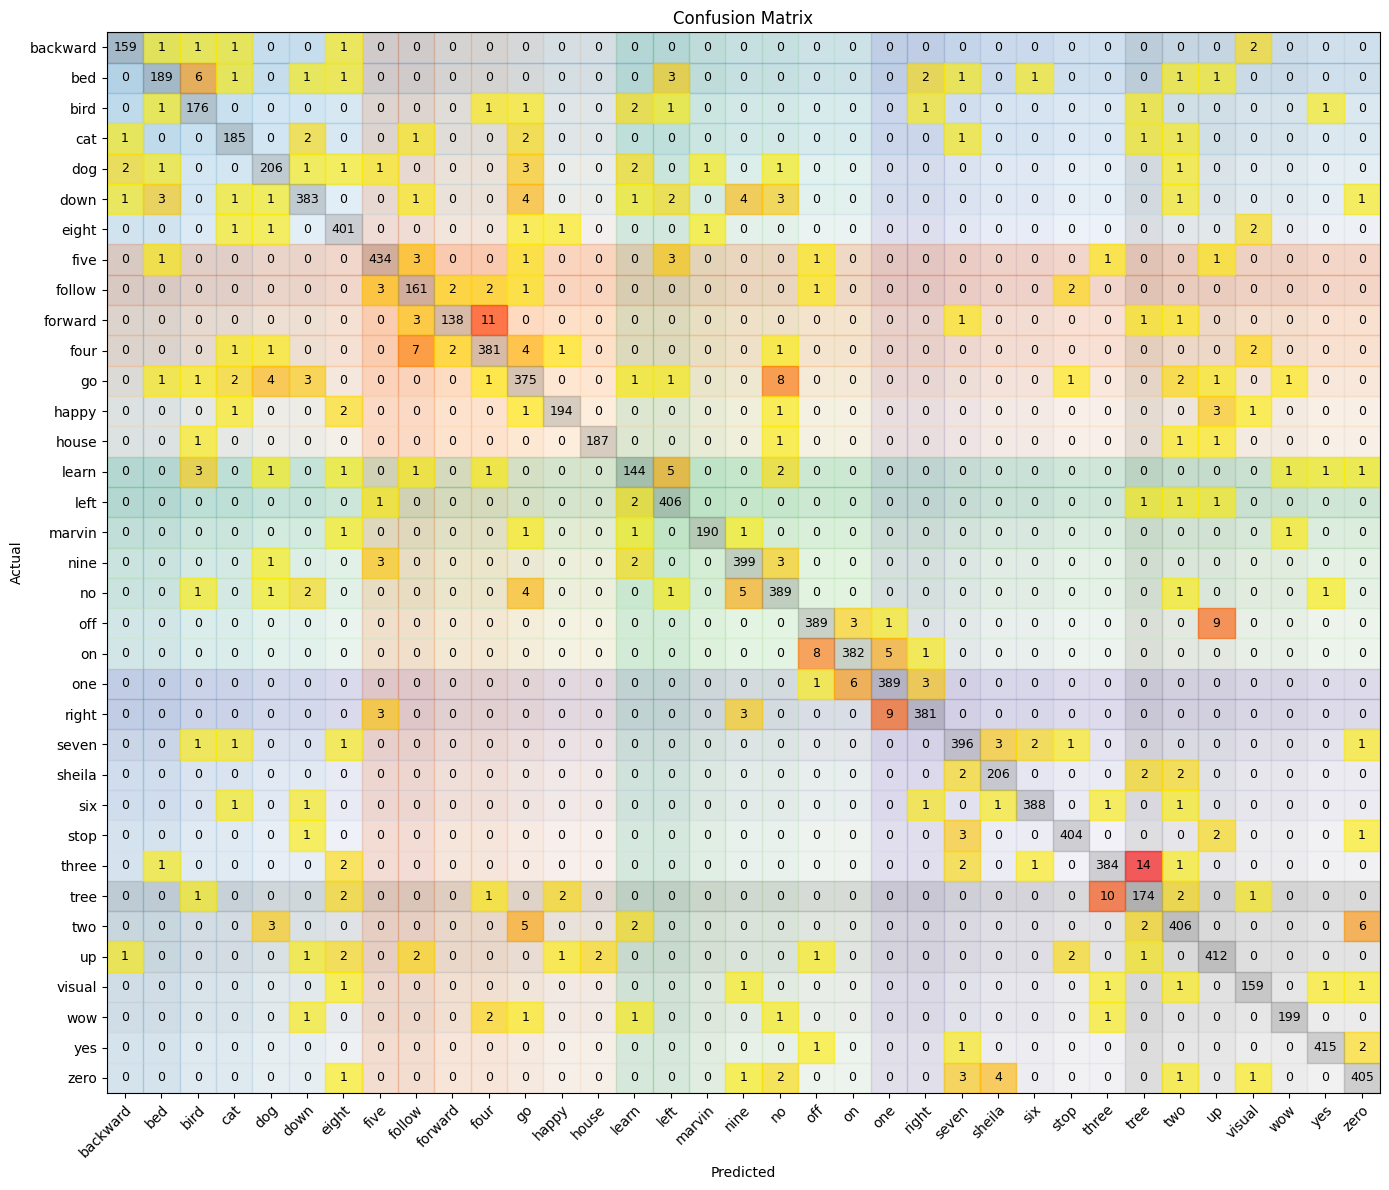

In [22]:
num_classes = len(cm)

# Create a figure with a white background
plt.figure(figsize=(14, 12), facecolor='white')
ax = plt.gca()

# Get unique colors for each class
colors = plt.cm.tab20c(np.linspace(0, 1, num_classes))

# Apply column colors
for col in range(num_classes):
    # Create a semi-transparent rectangle
    rect = plt.Rectangle((col - 0.5, -0.5), 1, num_classes, color=colors[col], alpha=0.2, zorder=-1)
    ax.add_patch(rect)

# Apply row colors
for row in range(num_classes):
    rect = plt.Rectangle((-0.5, row - 0.5), num_classes, 1, color=colors[row], alpha=0.2, zorder=-1)
    ax.add_patch(rect)

# get max non-diagonal value
max_value_non_diag = 0
for i in range(num_classes):
    for j in range(num_classes):
        if i != j:
            if cm[i, j] > max_value_non_diag:
                max_value_non_diag = cm[i, j]

# create color map using max_value_non_diag
highlight_colors = plt.cm.autumn_r(np.linspace(0, 1, max_value_non_diag + 1))

# add text and highlight non-zero values
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=9)
        # make non-zero values more visible (but not diagonals)
        if cm[i, j] > 0 and i != j:
            rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=highlight_colors[cm[i, j]], alpha=0.6, zorder=-1)
            ax.add_patch(rect)
        

# color diagonal cells unique color
for i in range(num_classes):
    rect = plt.Rectangle((i - 0.5, i - 0.5), 1, 1, color='gray', alpha=0.3, zorder=-1)
    ax.add_patch(rect)


# Setup the axes
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

# Rotate the x labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Set limits to ensure all cells are visible
ax.set_xlim(-0.5, num_classes - 0.5)
ax.set_ylim(num_classes - 0.5, -0.5)  # Invert y-axis to match conventional matrix display

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()

### Confusion Matrix to CSV

In [ ]:
# output confusion matrix to CSV
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
cm_df.to_csv("confusion_matrix.csv")

## nnViewer

In [ ]:
from nnViewer import wrap_model, run_gui
from team14.models.ryan_resnet import ResNet


# load a torch model
saved_model = torch.load("../models/cnn_ryan/250307-0336/rn19_epoch_14.pt", weights_only=False)
# move to cpu as otherwise nnViewer won't work
device = 'cpu' 
saved_model.to(device)

# Wrap the model using nnViewer's wrap_model function
wrapped_model = wrap_model(saved_model)

# grab an image
img = Image.open("../data/images/Speech Commands/backward/0ba018fc_nohash_1.png").convert('RGB')

# display the image
img.show()

image_size = (256, 190)
data_transforms = transforms.Compose([
    transforms.Resize((image_size[0], image_size[1])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
img = data_transforms(img).unsqueeze(0)  # [1, 3, 256, 190]

# do a forward pass on the image
saved_model.eval()  # Set the model to evaluation mode to disable dropout, etc.
with torch.no_grad():
    output = saved_model(img)

In [ ]:
# Launch the nnViewer GUI
run_gui(wrapped_model.graph)